In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from scipy import spatial
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
liked_songs = pd.read_parquet('datasets/cleaned/music-recommendation-system/liked/personal-playlists.parquet')
unheard_discover_weekly_songs = pd.read_parquet('datasets/cleaned/music-recommendation-system/unheard/discover-weekly.parquet')
unheard_categorized_songs = pd.read_parquet('datasets/cleaned/music-recommendation-system/unheard/categories.parquet')
unheard_songs = pd.concat([unheard_discover_weekly_songs, unheard_categorized_songs], ignore_index=True)
unheard_songs = pd.get_dummies(unheard_songs, columns=['key'], dtype=int)
df = pd.concat([liked_songs, unheard_discover_weekly_songs[unheard_discover_weekly_songs['like'].notnull()]], ignore_index=True)
df = pd.get_dummies(df, columns=['key'], dtype=int)
cols = list(df.columns.values)
cols.pop(cols.index('like'))
cols.pop(cols.index('listen'))
df = df.drop_duplicates(subset=['title', 'artist(s)'], keep='first')
df = df[cols+['listen', 'like']]
df['listen'] = df['listen'].astype(int)
df['like'] = df['like'].astype(int)

In [8]:
column_list = [
  'popularity', 'danceability', 'energy',
  'loudness', 'mode', 'speechiness', 'acousticness',
  'instrumentalness', 'liveness', 'valence', 'tempo',
  'duration_ms', 'time_signature', 'mode'
]

The following are the metadata of each song in the dataset:
1. `acousticness`: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
2. `danceability`: Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
3. `duration_ms`: The duration of the track in milliseconds.
4. `energy`: a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
5. `instrumentalness`: predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
6. `key`: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. (range `-1` to `11`)
7. `liveliness`: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
8. `mode`: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
9. `speechiness`: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
10. `tempo`: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
11. `time_signature`: An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".
12. `valence`: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

`acousticness`, `danceability`, `energy`, `instrumentalness`, `liveness`, `speechiness`, and `valence` are all floats between 0 and 1. However, `mode` is already one-hot encoded, so it is not necessary to normalize it. Only `duration_ms`, `tempo`, and `time_signature` are all integers, and they are not between 0 and 1 and need to be normalized. Only `key` would be one-hot encoded.

# Data Exploration

According to Spotify API, the popularity value will be between 0 and 100, with 100 being the most popular. From the graph below we can see that most of the songs that I listen to are quite popular, but not very popular. This is because I listen to a lot of mainstream music, but I also listen to some less popular music.

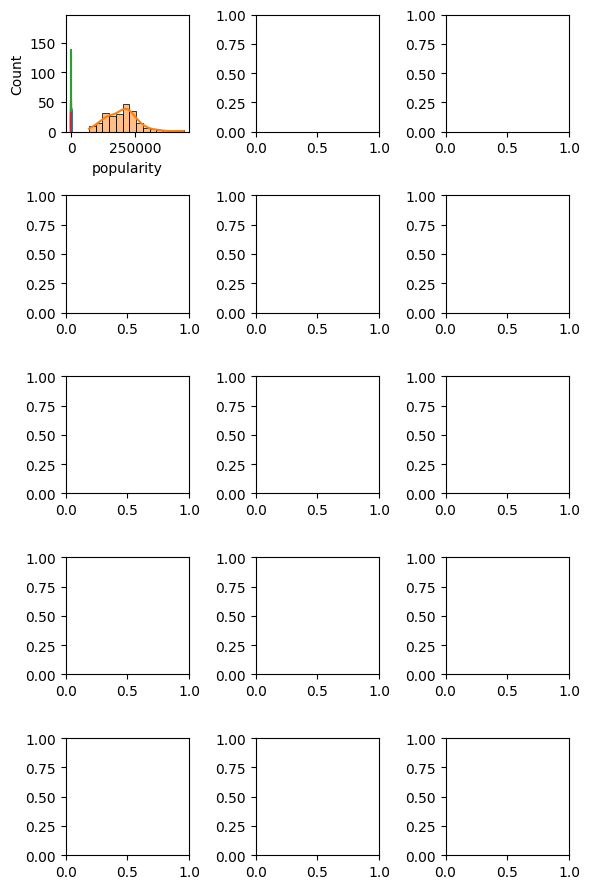

In [10]:
fig, axes = plt.subplots(5, 3, figsize=(6, 9))

col, row = 0, 0

for column in column_list:
    sns.histplot(df[column], kde=True, ax=axes[row, col])
    col += 1
    col, row = 0, row + 1 if row == 3 else row

plt.tight_layout()
plt.show()

<AxesSubplot: title={'center': 'Diagonal Correlation Matrix'}>

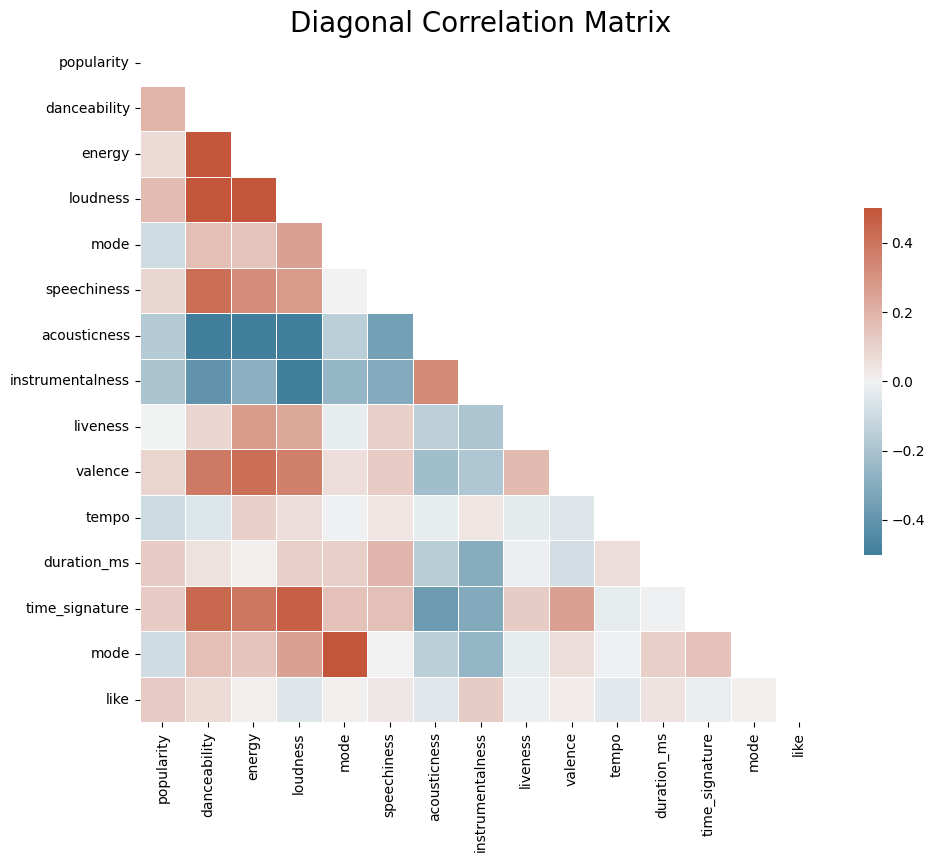

In [ ]:
corr = df[column_list + ['like']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.title('Diagonal Correlation Matrix', fontsize=20)
sns.heatmap(
  corr, mask=mask, cmap=cmap, 
  vmax=.5, vmin=-.5, center=0,
  square=True, linewidths=.5, cbar_kws={"shrink": .5}
)

In [ ]:
# check for duplicates in df
len(df[df.duplicated(subset=['id'], keep=False)].sort_values(by=['id']))

38

In [ ]:
tobe_normalized_columns = ['duration_ms', 'tempo', 'time_signature']

normalized_favorite_songs_df = df.copy()
for column in tobe_normalized_columns:
  normalized_favorite_songs_df[column] = normalize(df[[column]], axis=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    normalized_favorite_songs_df.drop(
        [column for column in normalized_favorite_songs_df.columns if normalized_favorite_songs_df[column].dtype == 'object'],
        axis = 1
    ),
    normalized_favorite_songs_df['like'], 
    test_size = 0.3, 
    random_state = 42
)

/var/folders/tb/18zmpr1n5g75rvhr7gcgx2600000gn/T/ipykernel_35501/1930718980.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)
/var/folders/tb/18zmpr1n5g75rvhr7gcgx2600000gn/T/ipykernel_35501/1930718980.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 2)


([<matplotlib.axis.XTick at 0x29337c5e0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

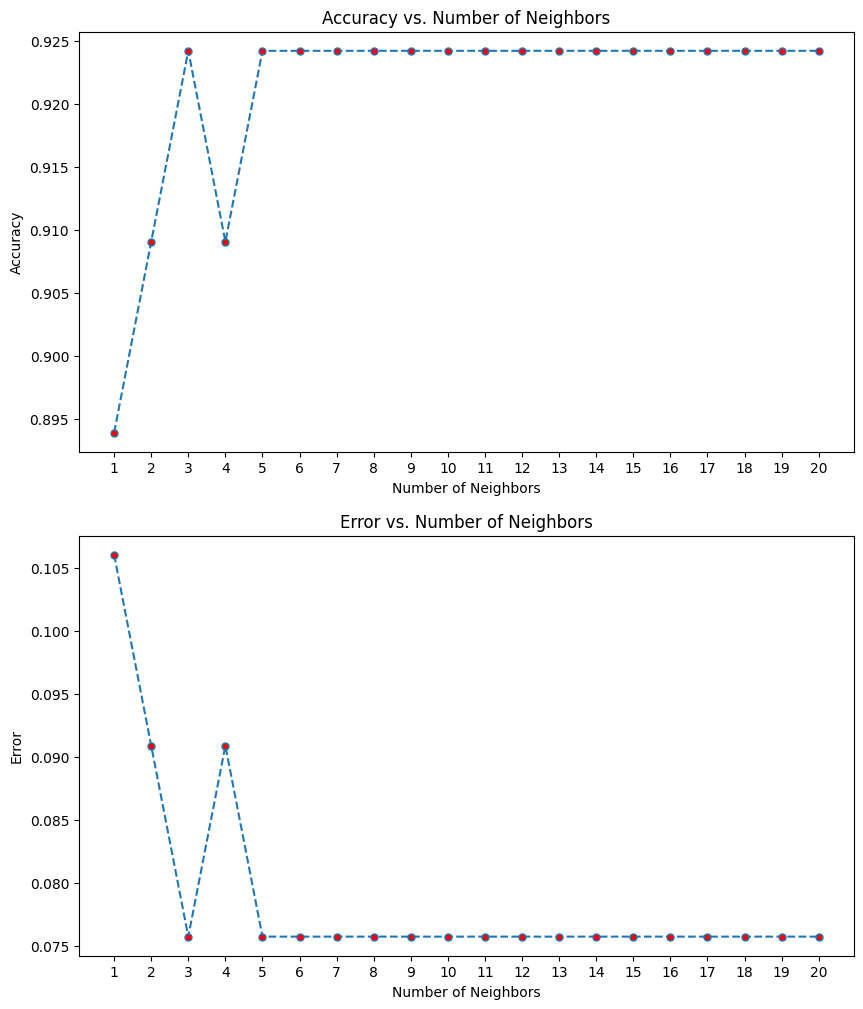

In [ ]:
fig, axes = plt.subplots(6, 3, figsize=(10, 12))
neighbors = np.arange(1, 21, 1)
accuracy = list()
error = list()

for n in neighbors:
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(X_train, y_train)
  accuracy.append(knn.score(X_test, y_test))
  error.append(np.mean(y_test != knn.predict(X_test)))

plt.subplot(2, 1, 1)
plt.plot(neighbors, accuracy, linestyle='dashed', marker='o', markerfacecolor='red', markersize=5)
plt.title('Accuracy vs. Number of Neighbors')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.xticks(np.arange(1, 21, 1))

plt.subplot(2, 1, 2)
plt.plot(neighbors, error, linestyle='dashed', marker='o', markerfacecolor='red', markersize=5)
plt.title('Error vs. Number of Neighbors')
plt.ylabel('Error')
plt.xlabel('Number of Neighbors')
plt.xticks(np.arange(1, 21, 1))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f'Accuracy: {knn.score(X_test, y_test)}')

Accuracy: 0.9242424242424242


In [ ]:
standardized_categorized_songs = unheard_categorized_songs.copy()
standardized_discover_weekly_songs = unheard_discover_weekly_songs.copy()

for column in tobe_normalized_columns:
  standardized_unheard_songs[column] = normalize(standardized_unheard_songs[[column]], axis=0)
  standardized_discover_weekly_songs[column] = normalize(standardized_discover_weekly_songs[[column]], axis=0)

In [35]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(standardized_unheard_notliked_discover_weekly_songs_df[tobe_standardized_columns])
y_pred

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [36]:
predicted_discover_weekly_songs = unheard_discover_weekly.copy()
predicted_discover_weekly_songs.loc[predicted_discover_weekly_songs['like'].isnull(), 'like'] = y_pred
predicted_discover_weekly_songs['like'] = predicted_discover_weekly_songs['like'].astype(int)

In [37]:
predicted_discover_weekly_songs[predicted_discover_weekly_songs['like'] == 1].to_parquet(
    'datasets/cleaned/music-recommendation-system/recommended/discover-weekly/yes.parquet'
)

predicted_discover_weekly_songs[predicted_discover_weekly_songs['like'] == 0].to_parquet(
    'datasets/cleaned/music-recommendation-system/recommended/discover-weekly/no.parquet'
)

In [38]:
unheard_notliked_songs = unheard_songs[unheard_songs['like'].isnull()]

In [39]:
unstandardized_unheard_notliked_songs_df = unheard_notliked_songs[tobe_standardized_columns].copy()
standardized_unheard_notliked_songs_values = scaler.fit_transform(unstandardized_unheard_notliked_songs_df)
standardized_unheard_notliked_songs_df = pd.DataFrame(standardized_unheard_notliked_songs_values, columns=tobe_standardized_columns)
standardized_unheard_notliked_songs_df['id'] = unheard_notliked_songs['id']
standardized_unheard_notliked_songs_df['listen'] = unheard_notliked_songs['listen']
standardized_unheard_notliked_songs_df.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,id,listen
0,1.175163,-0.815145,0.733784,0.224747,0.189932,-1.372581,-0.291709,-0.766357,-0.335930,1.223364,0.080875,1.959752,0.524358,0.213602,6ZZf5a8oiInHDkBe9zXfLP,0
1,0.762717,1.532085,0.571000,-1.183632,0.485082,0.728555,-0.477889,-0.893541,-0.335926,-0.788442,2.391734,-0.228800,-0.762322,0.213602,3FyfTh70PkgooRDe4SNP0U,0
2,1.484497,0.613904,0.390128,-1.465307,0.905067,0.728555,-0.090359,-0.877643,-0.335917,-1.090570,0.969330,-0.156205,0.025952,0.213602,4DHcnVTT87F0zZhRPYmZ3B,0
3,0.917384,-0.193819,0.390128,-0.056929,-0.051027,0.728555,-0.590976,-0.931260,-0.335584,-0.132643,-1.540227,0.136695,-0.477717,0.213602,1rBTBbtkJlSDk78gg8Dw9F,0
4,0.608051,-0.483771,-0.545880,0.788099,-0.520043,0.728555,-0.396522,0.755170,-0.335942,-0.386398,-0.715671,-0.083646,-0.578365,0.213602,3DBJE1Zndql25OGUQSv7aD,0


In [40]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(standardized_unheard_notliked_songs_df[tobe_standardized_columns])
unheard_notliked_songs['like'] = y_pred

In [41]:
unheard_notliked_songs['like'].value_counts()

like
1    1012
0      32
Name: count, dtype: int64

In [42]:
unheard_notliked_songs[unheard_notliked_songs['like'] == 1].to_parquet(
    'datasets/cleaned/music-recommendation-system/recommendation/categories/yes.parquet',
    index=False
)

unheard_notliked_songs[unheard_notliked_songs['like'] == 0].to_parquet(
    'datasets/cleaned/music-recommendation-system/recommendation/categories/no.parquet',
    index=False
)

In [19]:
# get the index value of the songs that like == 0 
unheard_notliked_songs[unheard_notliked_songs['like'] == 0].index

Index([  10,   53,   58,  103,  140,  142,  236,  252,  258,  294,  414,  451,
        493,  515,  741,  798,  814,  826,  833,  916,  945,  948,  964,  965,
        966,  976, 1009, 1019, 1025, 1026, 1027, 1037],
      dtype='int64')

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

# get the id of the disliked songs
dislike_song_ids = unheard_notliked_songs[unheard_notliked_songs['like'] == 0]['id'].values

# get the cosine similarity matrix, excluding the ids in dislike_song_ids
cosine_sim_matrix = cosine_similarity(standardized_favorite_songs_values, standardized_unheard_notliked_songs_values[~unheard_notliked_songs['id'].isin(dislike_song_ids)])

In [21]:
cosine_sim_matrix[:10]

array([[-0.13844482, -0.11507174, -0.23543195, ..., -0.47516885,
        -0.22624599,  0.15026421],
       [ 0.24608324, -0.31672802, -0.32489089, ..., -0.46172093,
         0.01666095, -0.23238758],
       [ 0.25597107, -0.34985527, -0.3193678 , ..., -0.70763744,
        -0.1586914 ,  0.44039179],
       ...,
       [-0.15018148, -0.36368659, -0.48589837, ..., -0.42301055,
        -0.03110198,  0.03037939],
       [ 0.07095339, -0.45917758, -0.42530403, ..., -0.57960734,
        -0.14037412,  0.07676045],
       [ 0.01343401, -0.51785812, -0.52022316, ..., -0.42874138,
        -0.03814977,  0.27877034]])

In [22]:
similarity_scores = cosine_sim_matrix[:10]
print(similarity_scores)

[[-0.13844482 -0.11507174 -0.23543195 ... -0.47516885 -0.22624599
   0.15026421]
 [ 0.24608324 -0.31672802 -0.32489089 ... -0.46172093  0.01666095
  -0.23238758]
 [ 0.25597107 -0.34985527 -0.3193678  ... -0.70763744 -0.1586914
   0.44039179]
 ...
 [-0.15018148 -0.36368659 -0.48589837 ... -0.42301055 -0.03110198
   0.03037939]
 [ 0.07095339 -0.45917758 -0.42530403 ... -0.57960734 -0.14037412
   0.07676045]
 [ 0.01343401 -0.51785812 -0.52022316 ... -0.42874138 -0.03814977
   0.27877034]]


In [23]:
top_indeces = similarity_scores.argsort()[::-1][:5]
print(top_indeces)

[[ 574   86  589 ...  415 1002  363]
 [ 574  277  274 ...  512  822  404]
 [ 192  373  863 ...  508  411  430]
 [ 192   86  863 ...  949  411  430]
 [ 529  559  583 ...   75  426  430]]


In [24]:
for index in top_indeces[:1]:
  print(unheard_notliked_songs.iloc[index][['title']][:5])

                      title
574     If I Can't Have You
86   Before the Petals Fall
589              Bad Habits
82              Padam Padam
559               Attention


In [25]:
related_songs = list()

for index, related_song_ids in enumerate(top_indeces[:10, :10]):
    related_songs.append({
        'id': index,
        'title': unheard_notliked_songs.iloc[index]['title'],
        'related_song_titles': [unheard_notliked_songs.iloc[index]['title'] for index in related_song_ids]
    })

print(related_songs[0])

{'id': 0, 'title': 'Curtains', 'related_song_titles': ["If I Can't Have You", 'Before the Petals Fall', 'Bad Habits', 'Padam Padam', 'Attention', 'I Like That', 'willow', 'KILLKA', 'Hurt', 'Blue']}


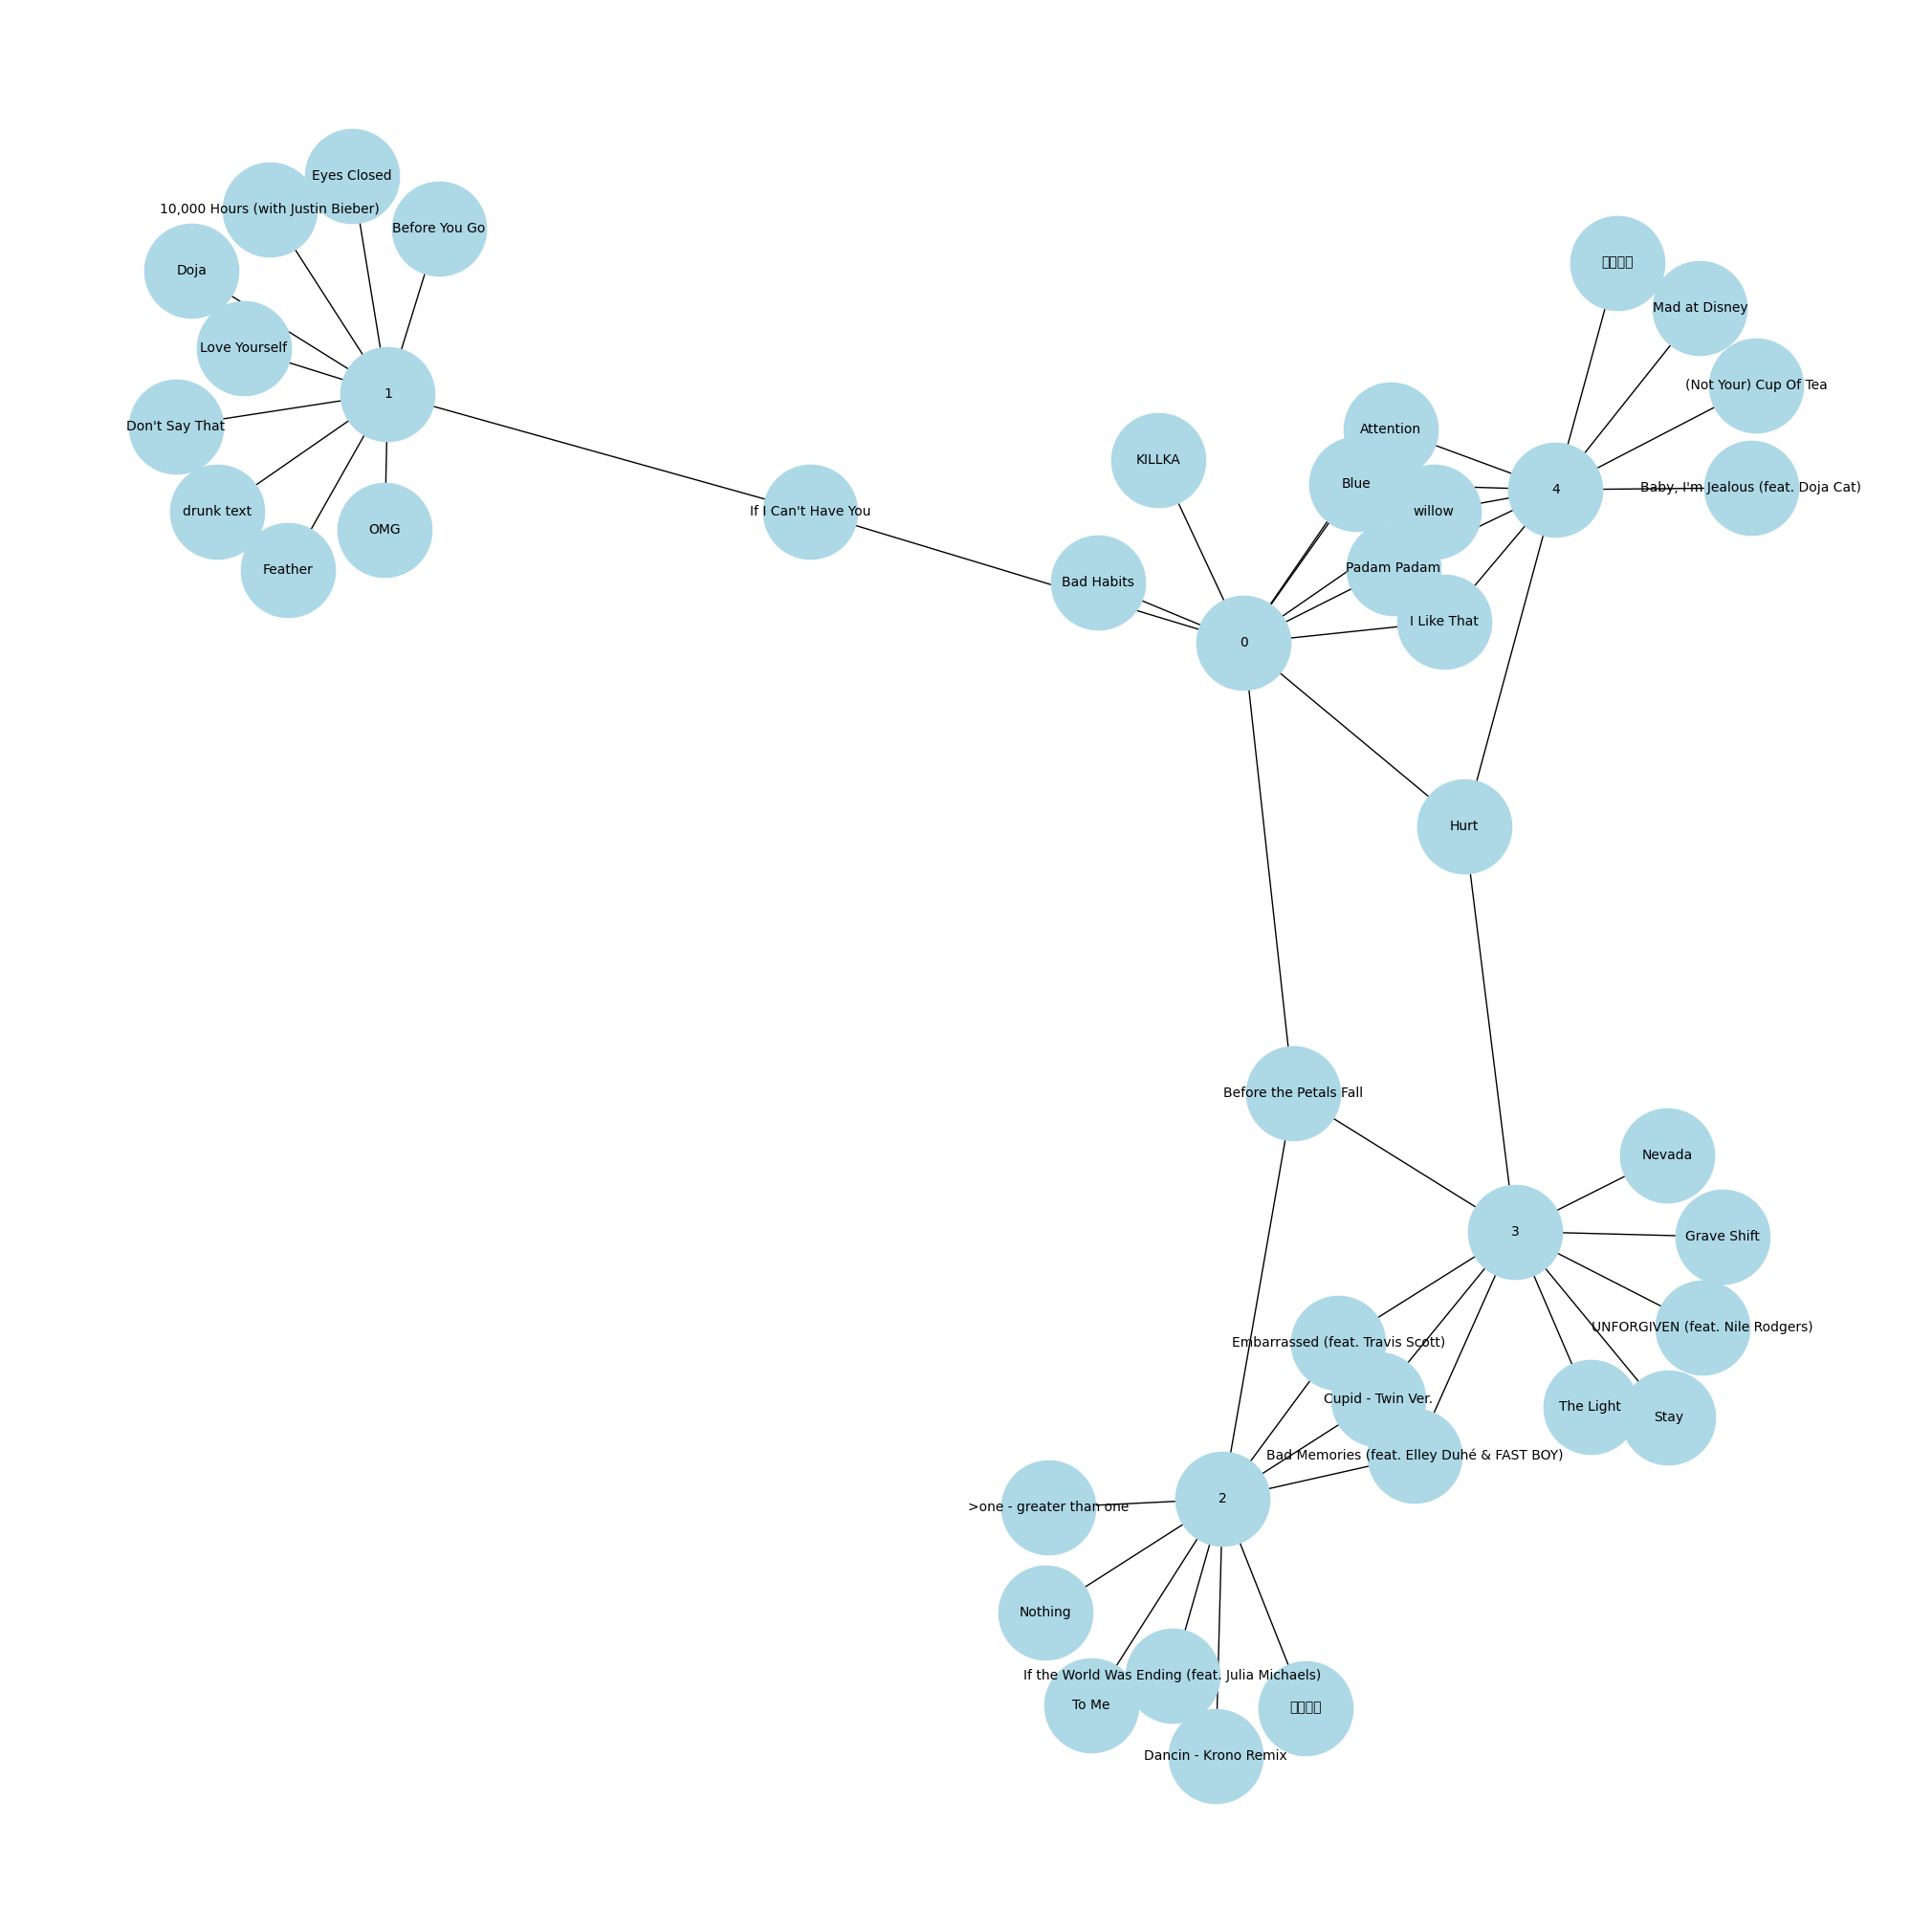

In [139]:
import networkx as nx

# Create a NetworkX graph
G = nx.Graph()

for song in related_songs:
    G.add_node(song['id'], title=song['title'])
    for related_song_title in song['related_song_titles']:
        G.add_edge(song['id'], related_song_title)

# increase graph size
plt.figure(figsize=(20, 20))

# Draw the resulting graph
nx.draw(G, with_labels=True, node_color='lightblue', node_size=5000, font_size=10)